# WindowGenerator

https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class WindowGenerator():
    def __init__(self,
                 input_width,
                 label_width,
                 shift,
                 train_df,
                 val_df,
                 test_df,
                 label_columns=None):
        #raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        #label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        #window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size : {self.total_window_size}',
            f'Input indices : {self.input_indices}',
            f'Label indices : {self.label_indices}',
            f'Label column name(s) : {self.label_columns}'
        ])

In [3]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
    #set shape manually to make the tf.data.Dataset objetcs easier to inspect
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

In [4]:
WindowGenerator.split_window = split_window

In [5]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    return ds

In [6]:
WindowGenerator.make_dataset = make_dataset

In [7]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of inputs, labels for plotting"""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the train dataset
        result = next(iter(self.train))
        # Cache it
        self._example = result
    
    return result

In [8]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [9]:
class BaseLine(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [10]:
def plot(self, model, plot_col, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12,8))
    plot_col_index = self.column_indices[plot_col]
    
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
        
        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
    
    plt.xlabel('Time')

In [11]:
WindowGenerator.plot = plot

In [12]:
MAX_EPOCHS = 20

In [13]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

#

In [14]:
data_raw = pd.read_table('data/MSFT.csv', sep=',')
high_raw = data_raw.loc[:, ['High']]

high_test = high_raw[1489:]
high_raw = high_raw[:1489]

n = len(high_raw)
high_train = high_raw[:int(n*0.8)]
high_val = high_raw[int(n*0.8):]

high_mean = np.mean(high_train)
high_std = np.std(high_train)

high_train = (high_train - high_mean) / high_std
high_test = (high_test - high_mean) / high_std
high_val = (high_val - high_mean) / high_std

#

In [15]:
window = WindowGenerator(
    input_width=2,
    label_width=2,
    shift=2,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [16]:
window

Total window size : 4
Input indices : [0 1]
Label indices : [2 3]
Label column name(s) : ['High']

In [17]:
baseline = BaseLine(label_index=window.column_indices['High'])

In [18]:
baseline.compile(
    loss = tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

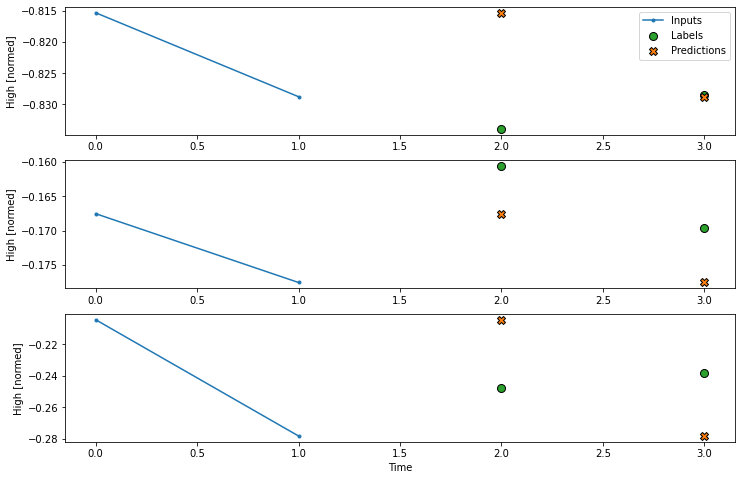

In [19]:
window.plot(baseline, plot_col='High')

#

In [20]:
window_2 = WindowGenerator(
    input_width=12,
    label_width=1,
    shift=1,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [21]:
window_2

Total window size : 13
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices : [12]
Label column name(s) : ['High']

In [22]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape((1, -1))
])

In [23]:
history = compile_and_fit(multi_step_dense, window_2)

Epoch 1/20
37/37 [==============================] - 1s 6ms/step - loss: 0.4221 - mean_absolute_error: 0.3783 - val_loss: 0.4600 - val_mean_absolute_error: 0.6339
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0634 - val_loss: 0.1521 - val_mean_absolute_error: 0.3462
Epoch 3/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0511 - val_loss: 0.0778 - val_mean_absolute_error: 0.2331
Epoch 4/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0458 - val_loss: 0.0610 - val_mean_absolute_error: 0.2005
Epoch 5/20
37/37 [==============================] - 0s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0440 - val_loss: 0.0713 - val_mean_absolute_error: 0.2224
Epoch 6/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0412 - val_loss: 0.0595 - val_mean_absolute_error: 0.1993
Epoch 7/20
37/37 [==========

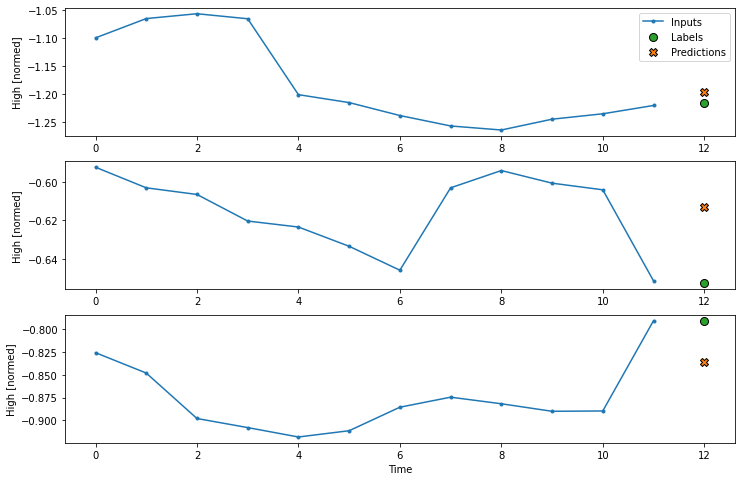

In [24]:
window_2.plot(multi_step_dense, plot_col='High')

In [29]:
unit_input = np.array([[1,1,1,1,1,1,1,1,1,1,1,1]])
unit_input_tensor = tf.constant(unit_input)

In [30]:
print(window_2.example[0].shape)
print(window_2.example[1].shape)

(32, 12, 1)
(32, 1, 1)


In [31]:
print(multi_step_dense.input_shape)
print(multi_step_dense.output_shape)

(None, 12, 1)
(None, 1, 1)


In [32]:
multi_step_dense(unit_input_tensor)

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[0.9787528]]], dtype=float32)>

#

In [36]:
window_3 = WindowGenerator(
    input_width=5,
    label_width=5,
    shift=2,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [37]:
window_3

Total window size : 7
Input indices : [0 1 2 3 4]
Label indices : [2 3 4 5 6]
Label column name(s) : ['High']

In [38]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [39]:
history_3 = compile_and_fit(lstm_model, window_3)

Epoch 1/20
38/38 [==============================] - 2s 18ms/step - loss: 0.5806 - mean_absolute_error: 0.6491 - val_loss: 6.6232 - val_mean_absolute_error: 2.4013
Epoch 2/20
38/38 [==============================] - 0s 5ms/step - loss: 0.2514 - mean_absolute_error: 0.3754 - val_loss: 3.9156 - val_mean_absolute_error: 1.6772
Epoch 3/20
38/38 [==============================] - 0s 5ms/step - loss: 0.1873 - mean_absolute_error: 0.3158 - val_loss: 3.5677 - val_mean_absolute_error: 1.6163
Epoch 4/20
38/38 [==============================] - 0s 5ms/step - loss: 0.1532 - mean_absolute_error: 0.2759 - val_loss: 3.0020 - val_mean_absolute_error: 1.4815
Epoch 5/20
38/38 [==============================] - 0s 5ms/step - loss: 0.1187 - mean_absolute_error: 0.2335 - val_loss: 2.3218 - val_mean_absolute_error: 1.2881
Epoch 6/20
38/38 [==============================] - 0s 5ms/step - loss: 0.0888 - mean_absolute_error: 0.1931 - val_loss: 1.6379 - val_mean_absolute_error: 1.0220
Epoch 7/20
38/38 [=========

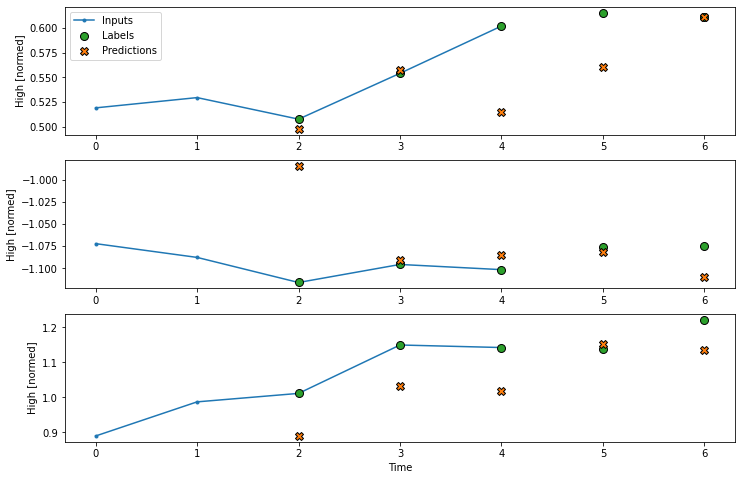

In [40]:
window_3.plot(lstm_model, plot_col='High')

In [41]:
print(lstm_model.input_shape)
print(lstm_model.output_shape)

(None, 5, 1)
(None, 5, 1)


In [42]:
print(window_3.example[0].shape)
print(window_3.example[1].shape)

(32, 5, 1)
(32, 5, 1)


In [43]:
test_input = tf.constant(np.array([[[1],[1],[1],[1],[1]]]))

In [44]:
lstm_model(test_input)

<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[1.0054572],
        [1.039854 ],
        [1.0078545],
        [1.0049367],
        [1.0085362]]], dtype=float32)>

#

In [45]:
window_4 = WindowGenerator(
    input_width=10,
    label_width=6,
    shift=1,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [46]:
window_4

Total window size : 11
Input indices : [0 1 2 3 4 5 6 7 8 9]
Label indices : [ 5  6  7  8  9 10]
Label column name(s) : ['High']

In [47]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(5,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [48]:
history_4 = compile_and_fit(conv_model, window_4)

Epoch 1/20
37/37 [==============================] - 1s 6ms/step - loss: 0.7395 - mean_absolute_error: 0.7402 - val_loss: 1.6558 - val_mean_absolute_error: 1.2386
Epoch 2/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0907 - mean_absolute_error: 0.2099 - val_loss: 0.0324 - val_mean_absolute_error: 0.1308
Epoch 3/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0064 - mean_absolute_error: 0.0629 - val_loss: 0.0326 - val_mean_absolute_error: 0.1359
Epoch 4/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0531 - val_loss: 0.0339 - val_mean_absolute_error: 0.1394


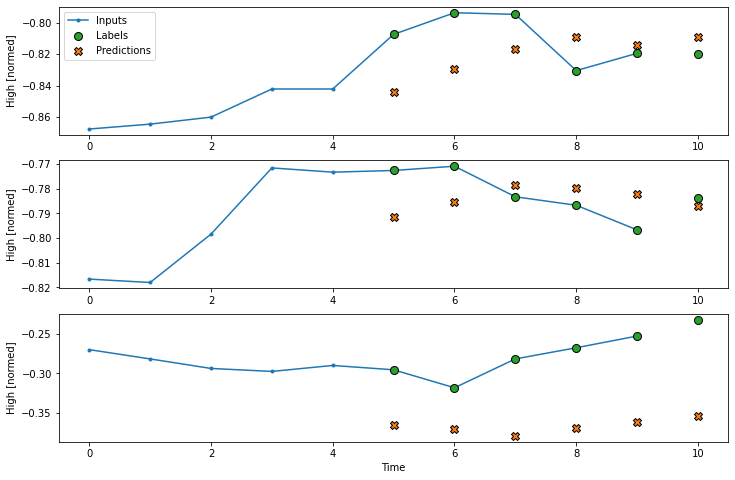

In [49]:
window_4.plot(conv_model, plot_col='High')

#

In [50]:
window_5 = WindowGenerator(
    input_width=12,
    label_width=1,
    shift=1,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [51]:
window_5

Total window size : 13
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices : [12]
Label column name(s) : ['High']

In [52]:
lstm_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape((1, -1))
])

In [53]:
history_5 = compile_and_fit(lstm_model_2, window_5)

Epoch 1/20
37/37 [==============================] - 2s 14ms/step - loss: 0.3640 - mean_absolute_error: 0.4548 - val_loss: 2.9999 - val_mean_absolute_error: 1.5024
Epoch 2/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0195 - mean_absolute_error: 0.1158 - val_loss: 3.0381 - val_mean_absolute_error: 1.5370
Epoch 3/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0119 - mean_absolute_error: 0.0882 - val_loss: 2.6231 - val_mean_absolute_error: 1.4150
Epoch 4/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_absolute_error: 0.0711 - val_loss: 2.2166 - val_mean_absolute_error: 1.2847
Epoch 5/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0581 - val_loss: 1.8530 - val_mean_absolute_error: 1.1532
Epoch 6/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_absolute_error: 0.0494 - val_loss: 1.6337 - val_mean_absolute_error: 1.0682
Epoch 7/20
37/37 [=========

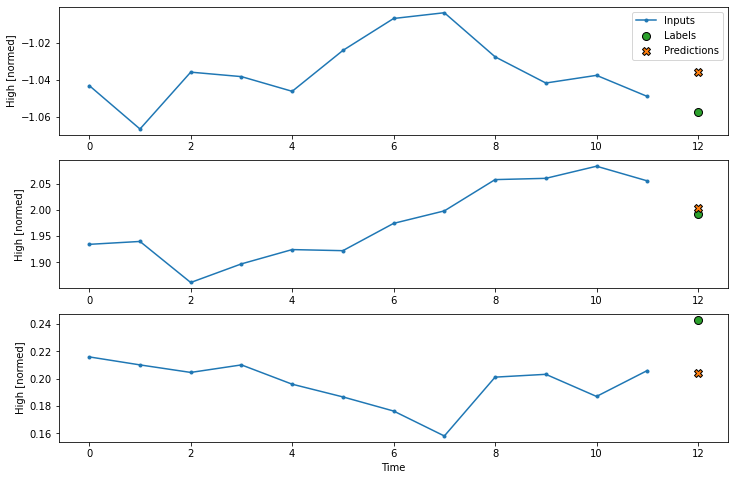

In [54]:
window_5.plot(lstm_model_2, plot_col='High')

In [67]:
print(window_5.example[0].shape)
print(window_5.example[1].shape)

(32, 12, 1)
(32, 1, 1)


In [68]:
print(lstm_model_2.input_shape)
print(lstm_model_2.output_shape)

(None, 12, 1)
(None, 1, 1)


In [69]:
test_input = tf.constant(np.array([[[1],[1],[1],[1],[1]]]))

In [70]:
lstm_model_2(test_input)

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[0.64694744]]], dtype=float32)>

#

In [63]:
window_6 = WindowGenerator(
    input_width=10,
    label_width=10,
    shift=10,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [64]:
window_6

Total window size : 20
Input indices : [0 1 2 3 4 5 6 7 8 9]
Label indices : [10 11 12 13 14 15 16 17 18 19]
Label column name(s) : ['High']

In [67]:
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(10, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([10, 1])
])

In [68]:
history_6 = compile_and_fit(multi_linear_model, window_6)

Epoch 1/20
37/37 [==============================] - 0s 5ms/step - loss: 0.9514 - mean_absolute_error: 0.8545 - val_loss: 13.3310 - val_mean_absolute_error: 3.5441
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.8839 - mean_absolute_error: 0.8234 - val_loss: 12.3856 - val_mean_absolute_error: 3.4160
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: 0.8197 - mean_absolute_error: 0.7928 - val_loss: 11.4793 - val_mean_absolute_error: 3.2885
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 0.7589 - mean_absolute_error: 0.7629 - val_loss: 10.6146 - val_mean_absolute_error: 3.1619
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 0.7018 - mean_absolute_error: 0.7334 - val_loss: 9.8143 - val_mean_absolute_error: 3.0401
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 0.6480 - mean_absolute_error: 0.7045 - val_loss: 9.0631 - val_mean_absolute_error: 2.9212
Epoch 7/20
37/37 [======

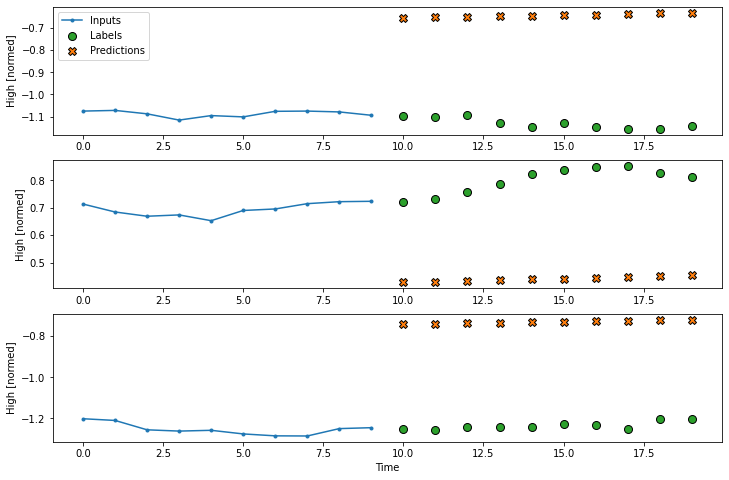

In [69]:
window_6.plot(multi_linear_model, plot_col='High')

In [73]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=10, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape((10, 1))
])

In [74]:
history_6b = compile_and_fit(multi_dense_model, window_6)

Epoch 1/20
37/37 [==============================] - 1s 6ms/step - loss: 0.4325 - mean_absolute_error: 0.5007 - val_loss: 0.5875 - val_mean_absolute_error: 0.6997
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0187 - mean_absolute_error: 0.1087 - val_loss: 0.4982 - val_mean_absolute_error: 0.6407
Epoch 3/20
37/37 [==============================] - 0s 4ms/step - loss: 0.0116 - mean_absolute_error: 0.0852 - val_loss: 0.3095 - val_mean_absolute_error: 0.4916
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 0.0100 - mean_absolute_error: 0.0785 - val_loss: 0.2643 - val_mean_absolute_error: 0.4500
Epoch 5/20
37/37 [==============================] - 0s 4ms/step - loss: 0.0085 - mean_absolute_error: 0.0710 - val_loss: 0.1868 - val_mean_absolute_error: 0.3689
Epoch 6/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0073 - mean_absolute_error: 0.0638 - val_loss: 0.1700 - val_mean_absolute_error: 0.3496
Epoch 7/20
37/37 [==========

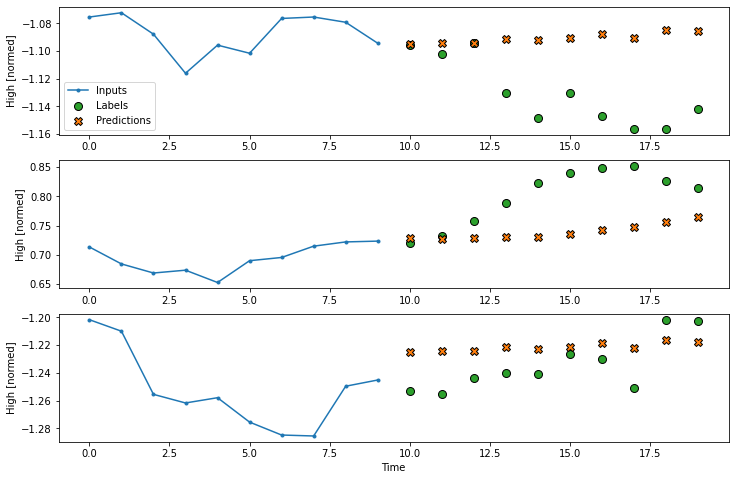

In [75]:
window_6.plot(multi_dense_model, plot_col='High')

In [76]:
CONV_WIDTH = 10

In [77]:
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(filters=256, activation='relu', kernel_size=(CONV_WIDTH,)),
    tf.keras.layers.Dense(units=10, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape((10, 1))
])

In [78]:
history_6c = compile_and_fit(multi_conv_model, window_6)

Epoch 1/20
37/37 [==============================] - 1s 6ms/step - loss: 0.3737 - mean_absolute_error: 0.4452 - val_loss: 0.3831 - val_mean_absolute_error: 0.5161
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_absolute_error: 0.0841 - val_loss: 0.0961 - val_mean_absolute_error: 0.2288
Epoch 3/20
37/37 [==============================] - 0s 4ms/step - loss: 0.0080 - mean_absolute_error: 0.0651 - val_loss: 0.1084 - val_mean_absolute_error: 0.2637
Epoch 4/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0078 - mean_absolute_error: 0.0635 - val_loss: 0.1164 - val_mean_absolute_error: 0.2802


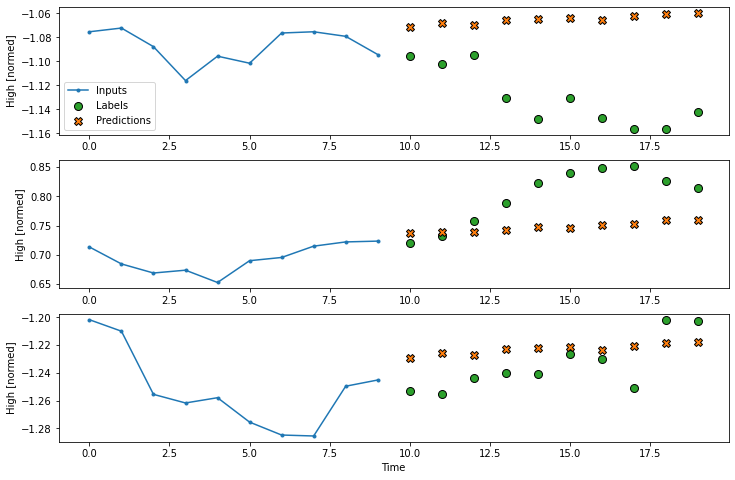

In [79]:
window_6.plot(multi_conv_model, plot_col='High')

In [80]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(10, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape((10, 1))
])

In [81]:
history_6d = compile_and_fit(multi_lstm_model, window_6)

Epoch 1/20
37/37 [==============================] - 2s 18ms/step - loss: 0.7603 - mean_absolute_error: 0.7535 - val_loss: 9.0904 - val_mean_absolute_error: 2.8778
Epoch 2/20
37/37 [==============================] - 0s 8ms/step - loss: 0.1683 - mean_absolute_error: 0.3315 - val_loss: 5.9959 - val_mean_absolute_error: 2.2789
Epoch 3/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0731 - mean_absolute_error: 0.2170 - val_loss: 4.8272 - val_mean_absolute_error: 2.0161
Epoch 4/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0384 - mean_absolute_error: 0.1534 - val_loss: 3.9877 - val_mean_absolute_error: 1.8021
Epoch 5/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0198 - mean_absolute_error: 0.1080 - val_loss: 3.3955 - val_mean_absolute_error: 1.6332
Epoch 6/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0123 - mean_absolute_error: 0.0834 - val_loss: 2.9856 - val_mean_absolute_error: 1.5055
Epoch 7/20
37/37 [=========

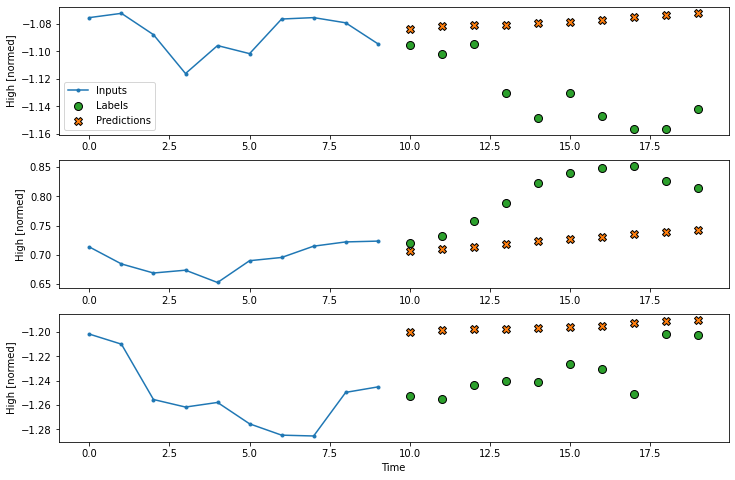

In [82]:
window_6.plot(multi_lstm_model, plot_col='High')

#

In [83]:
window_6

Total window size : 20
Input indices : [0 1 2 3 4 5 6 7 8 9]
Label indices : [10 11 12 13 14 15 16 17 18 19]
Label column name(s) : ['High']

In [84]:
window_6.example[0][0]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-1.0753955],
       [-1.0722913],
       [-1.087813 ],
       [-1.1160972],
       [-1.0957464],
       [-1.1016103],
       [-1.0764304],
       [-1.0753955],
       [-1.0791898],
       [-1.0943668]], dtype=float32)>

In [85]:
window_6.example[0][:,-2,:]

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-1.0791898 ],
       [ 0.72203326],
       [-1.2495852 ],
       [-0.45797127],
       [-0.60525644],
       [-0.08682708],
       [-1.0957464 ],
       [-0.88982344],
       [-1.0943668 ],
       [-1.1164422 ],
       [ 1.012119  ],
       [ 1.0949022 ],
       [-1.2181965 ],
       [-1.024001  ],
       [-0.8191129 ],
       [-0.7125296 ],
       [-1.1626629 ],
       [-0.41623482],
       [ 0.52231896],
       [-1.156799  ],
       [-0.45348728],
       [-0.00680338],
       [-0.28171244],
       [-1.0650476 ],
       [-0.6028419 ],
       [ 1.0034958 ],
       [ 0.9786608 ],
       [-0.8456723 ],
       [-0.61594915],
       [-0.6031868 ],
       [-0.25480768],
       [ 2.1224477 ]], dtype=float32)>